In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [216]:
#loading the first dataset in 

url = 'https://github.com/tmartabano/Project-for-Data-Munging/raw/main/2000-2019.csv'
df1 = pd.read_csv(url)
df1.head()
#standardizing some of the measures 
df1['tempo'] = df1['tempo'].round(0)
df1['main_genre'] = df1['genre'].str.split(',').str[0]
df1['year'] = df1['year'].astype(float)

df1.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,main_genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000.0,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.0,pop,pop
1,blink-182,All The Small Things,167066,False,1999.0,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,149.0,"rock, pop",rock
2,Faith Hill,Breathe,250546,False,1999.0,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,137.0,"pop, country",pop
3,Bon Jovi,It's My Life,224493,False,2000.0,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,120.0,"rock, metal",rock
4,*NSYNC,Bye Bye Bye,200560,False,2000.0,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,173.0,pop,pop


In [217]:
#loading in second dataset
url = 'https://raw.githubusercontent.com/tmartabano/Project-for-Data-Munging/main/top_10000_1960-now.csv'
df2 = pd.read_csv(url)

#standardizing some measures 
df2['Tempo'] = df2['Tempo'].round(0)
df2['year'] = df2['Album Release Date'].str[-2:].astype(float)

#separating the dates from < 2000 and after > 2000
df2.loc[df2['year'] < 50, 'year'] += 2000
df2.loc[df2['year'] < 100, 'year'] += 1900
df2['year']
df2 = df2.sort_values(by='year', ascending=False)
df2



,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album Release Date,Album Image URL,...,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights,year
9998,spotify:track:3iKuIfvoU50eww6EVzNqHo,Padam Padam,spotify:artist:4RVnAU35WRWra6OZ3CbbMA,Kylie Minogue,spotify:album:0OHc8STurn45gpk3dyIiw5,Padam Padam,spotify:artist:4RVnAU35WRWra6OZ3CbbMA,Kylie Minogue,5/19/23,https://i.scdn.co/image/ab67616d0000b2730536a8...,...,0.2140,0.001160,0.1030,0.711,128.0,4.0,NaN,Liberator Music,C 2023 Kylie Minogue/Darenote under exclusive ...,2023.0
9991,spotify:track:3AjSfp5FDvwtMU9XBsbS8j,Push Up - Main Edit,spotify:artist:2gW0M5fn2r7Lo4Hn1r8HZ5,Creeds,spotify:album:3v5BP6gPT1nNU9rjs57fF0,Push Up (Main Edit),spotify:artist:2gW0M5fn2r7Lo4Hn1r8HZ5,Creeds,3/31/23,https://i.scdn.co/image/ab67616d0000b273b1f8e7...,...,0.2090,0.836000,0.0582,0.187,75.0,4.0,NaN,Columbia/B1 Recordings,"P (P) 2023 Rave Alert Records, under exclusive...",2023.0
2428,spotify:track:3k79jB4aGmMDUQzEwa46Rz,vampire,spotify:artist:1McMsnEElThX1knmY4oliG,Olivia Rodrigo,spotify:album:5kqfR7EuGbyp8x27Pr1kY9,vampire,spotify:artist:1McMsnEElThX1knmY4oliG,Olivia Rodrigo,6/30/23,https://i.scdn.co/image/ab67616d0000b2731e5e75...,...,0.1690,0.000000,0.3110,0.322,138.0,4.0,NaN,Olivia Rodrigo PS,"C © 2023 Olivia Rodrigo, under exclusive licen...",2023.0
9935,spotify:track:6UbNrW8X1v4oOR29vzSVqX,One Day At A Time,"spotify:artist:2mF9PcfpN8vxRtCfra8hz1, spotify...","Thierry Von Der Warth, Jay Mason",spotify:album:5qrQjiR5PsDykstHLRAK23,One Day At A Time,"spotify:artist:2mF9PcfpN8vxRtCfra8hz1, spotify...","Thierry Von Der Warth, Jay Mason",3/3/23,https://i.scdn.co/image/ab67616d0000b2734fe2e6...,...,0.2240,0.000135,0.1170,0.526,122.0,4.0,NaN,Paraiso,"C 2023 Thierry Von Der Warth & Jay Mason, P 20...",2023.0
7789,spotify:track:5eTaQYBE1yrActixMAeLcZ,Miracle (with Ellie Goulding),"spotify:artist:7CajNmpbOovFoOoasH2HaY, spotify...","Calvin Harris, Ellie Goulding",spotify:album:22UyygZceCIfoE0RhENgKx,Miracle (with Ellie Goulding),"spotify:artist:7CajNmpbOovFoOoasH2HaY, spotify...","Calvin Harris, Ellie Goulding",3/10/23,https://i.scdn.co/image/ab67616d0000b273c58e22...,...,0.0378,0.044600,0.0808,0.306,143.0,4.0,NaN,Columbia,P (P) 2023 Sony Music Entertainment UK Limited,2023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356,spotify:track:33aYzW5ToRjiFOzkubeJ8H,Rave On,"spotify:artist:3wYyutjgII8LJVVOLrGI0D, spotify...","Buddy Holly, The Crickets",spotify:album:4Qy0SOU9Jg7Td10K68SanP,Buddy Holly,spotify:artist:3wYyutjgII8LJVVOLrGI0D,Buddy Holly,1958,https://i.scdn.co/image/ab67616d0000b27358816b...,...,0.6110,0.000007,0.4170,0.961,160.0,4.0,NaN,Geffen,"C © 1958 UMG Recordings Inc., P This Compilati...",1958.0
4106,spotify:track:6xNwKNYZcvgV3XTIwsgNio,Heartbreak Hotel,spotify:artist:43ZHCT0cAZBISjO8DG9PnE,Elvis Presley,spotify:album:0C3t1htEDTFKcg7F2rNbek,Elvis' Golden Records,spotify:artist:43ZHCT0cAZBISjO8DG9PnE,Elvis Presley,3/21/58,https://i.scdn.co/image/ab67616d0000b27320ee3e...,...,0.8400,0.000002,0.1070,0.717,94.0,4.0,NaN,RCA Records Label,P (P) 1958 Sony Music Entertainment,1958.0
7007,spotify:track:47gmoUrZV3w20JAnQOZMcO,Blue Suede Shoes,spotify:artist:43ZHCT0cAZBISjO8DG9PnE,Elvis Presley,spotify:album:7GXP5OhYyPVLmcVfO9Iqin,Elvis Presley,spotify:artist:43ZHCT0cAZBISjO8DG9PnE,Elvis Presley,3/23/56,https://i.scdn.co/image/ab67616d0000b273f45cec...,...,0.6540,0.000002,0.1380,0.962,95.0,4.0,NaN,RCA Victor,P (P) 1956 Sony Music Entertainment,1956.0
2714,spotify:local:The+Beatles:1962-1966:You%27ve+G...,You've Got To Hide Your Love Away,NaN,The Beatles,NaN,1962-1966,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
#sett of conditions to get the genre into usable data
conditions = [
    df2['Artist Genres'].str.contains('pop', case=False, na=False),
    df2['Artist Genres'].str.contains('rock', case=False, na=False),
    df2['Artist Genres'].str.contains('hip hop', case=False, na=False),
    df2['Artist Genres'].str.contains('country', case=False, na=False),
     df2['Artist Genres'].str.contains('soul', case=False, na=False)
]

#possible genres if not its other 
categories = ['pop', 'rock', 'hip hop', 'country','soul']

# Apply the conditions and assign categories
df2['Genre Category'] = np.select(conditions, categories, default='Other')
df2.head()

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album Release Date,Album Image URL,...,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights,year,Genre Category
9998,spotify:track:3iKuIfvoU50eww6EVzNqHo,Padam Padam,spotify:artist:4RVnAU35WRWra6OZ3CbbMA,Kylie Minogue,spotify:album:0OHc8STurn45gpk3dyIiw5,Padam Padam,spotify:artist:4RVnAU35WRWra6OZ3CbbMA,Kylie Minogue,5/19/23,https://i.scdn.co/image/ab67616d0000b2730536a8...,...,0.001160,0.1030,0.711,128.0,4.0,NaN,Liberator Music,C 2023 Kylie Minogue/Darenote under exclusive ...,2023.0,pop
9991,spotify:track:3AjSfp5FDvwtMU9XBsbS8j,Push Up - Main Edit,spotify:artist:2gW0M5fn2r7Lo4Hn1r8HZ5,Creeds,spotify:album:3v5BP6gPT1nNU9rjs57fF0,Push Up (Main Edit),spotify:artist:2gW0M5fn2r7Lo4Hn1r8HZ5,Creeds,3/31/23,https://i.scdn.co/image/ab67616d0000b273b1f8e7...,...,0.836000,0.0582,0.187,75.0,4.0,NaN,Columbia/B1 Recordings,"P (P) 2023 Rave Alert Records, under exclusive...",2023.0,Other
2428,spotify:track:3k79jB4aGmMDUQzEwa46Rz,vampire,spotify:artist:1McMsnEElThX1knmY4oliG,Olivia Rodrigo,spotify:album:5kqfR7EuGbyp8x27Pr1kY9,vampire,spotify:artist:1McMsnEElThX1knmY4oliG,Olivia Rodrigo,6/30/23,https://i.scdn.co/image/ab67616d0000b2731e5e75...,...,0.000000,0.3110,0.322,138.0,4.0,NaN,Olivia Rodrigo PS,"C © 2023 Olivia Rodrigo, under exclusive licen...",2023.0,pop
9935,spotify:track:6UbNrW8X1v4oOR29vzSVqX,One Day At A Time,"spotify:artist:2mF9PcfpN8vxRtCfra8hz1, spotify...","Thierry Von Der Warth, Jay Mason",spotify:album:5qrQjiR5PsDykstHLRAK23,One Day At A Time,"spotify:artist:2mF9PcfpN8vxRtCfra8hz1, spotify...","Thierry Von Der Warth, Jay Mason",3/3/23,https://i.scdn.co/image/ab67616d0000b2734fe2e6...,...,0.000135,0.1170,0.526,122.0,4.0,NaN,Paraiso,"C 2023 Thierry Von Der Warth & Jay Mason, P 20...",2023.0,Other
7789,spotify:track:5eTaQYBE1yrActixMAeLcZ,Miracle (with Ellie Goulding),"spotify:artist:7CajNmpbOovFoOoasH2HaY, spotify...","Calvin Harris, Ellie Goulding",spotify:album:22UyygZceCIfoE0RhENgKx,Miracle (with Ellie Goulding),"spotify:artist:7CajNmpbOovFoOoasH2HaY, spotify...","Calvin Harris, Ellie Goulding",3/10/23,https://i.scdn.co/image/ab67616d0000b273c58e22...,...,0.044600,0.0808,0.306,143.0,4.0,NaN,Columbia,P (P) 2023 Sony Music Entertainment UK Limited,2023.0,pop


In [219]:
#loading in the third and final dataset 

url = 'https://raw.githubusercontent.com/tmartabano/Project-for-Data-Munging/main/30ksongs.csv'
df3 = pd.read_csv(url)

# standardizing the year into a usable format
df3['year'] = pd.to_datetime(df3['track_album_release_date'], errors='coerce').dt.year
#df3['year'] = df3['year'].astype(float)
#df3 = df3.sort_values(by='year', ascending=False)

good_df = df3[df3['year'] < 2025]
error_df = df3[df3['year'] > 2025]

error_df = error_df.copy()
error_df.loc[error_df['year'] > 2025, 'year'] -= 100
fix_df = error_df

df3_b = pd.concat([good_df, fix_df], ignore_index=True)
df3_b['year'] = df3_b['year'].astype(float)

In [220]:
#test code block
df4 = df3[['track_name', 'track_artist', 'playlist_genre']]
df4['track_name'].groupby(df4['playlist_genre']).count()

playlist_genre
edm      6043
latin    5153
pop      5507
r&b      5431
rap      5743
rock     4951
Name: track_name, dtype: int64

In [221]:
#formatting the data we want into new dataframes with uniform column names 

# For df1
df4 = df1[['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']]
df4.columns = ['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']
# For df2
df5 = df2[['Track Name', 'Artist Name(s)', 'year', 'Track Duration (ms)', 'Key', 'Loudness', 'Mode', 'Tempo', 'Genre Category']]
df5.columns = ['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']
# For df3
df6 = df3_b[['track_name', 'track_artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'playlist_genre']]
df6.columns = ['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']

In [222]:
#start of new method 

df6 = df6.dropna()
df5 = df5.dropna()
df4 = df4.dropna()
missing_values = big_df.isnull().sum()
missing_values

song           0
artist         0
year           0
duration_ms    0
key            0
loudness       0
mode           0
tempo          0
main_genre     0
decade         0
minutes        0
dtype: int64

In [223]:
#joining the 3 dfs into 1 df and getting rid of missing values 
frames = [df4, df5, df6]
big_df = pd.concat(frames)
missing_values = big_df.isnull().sum()
missing_values
big_df.drop_duplicates(subset=['song'], inplace=True)
big_df = big_df[big_df['tempo'] != 0]
big_df['tempo'] = big_df['tempo'].round(0)

In [232]:
#code that fixes the issue with the year and creates decades column
condition = big_df['year'] > 2025
big_df.loc[condition, 'year'] -= 100
sorted_value_counts = big_df['year'].value_counts().sort_index(ascending=False)

big_df['decade'] = big_df['year'].astype(str).str[2:3] + '0s'
big_df['decade'] = big_df['decade'].replace({'50s': '1950s', '60s': '1960s', '70s': '1970s', '80s': '1980s', '90s': '1990s', '00s': '2000s', '10s': '2010s', '20s': '2020s'})
big_df['decade']

0        2000s
1        1990s
2        1990s
3        2000s
4        2000s
         ...  
32827    1970s
32828    1970s
32829    1960s
32830    1960s
32831    1960s
Name: decade, Length: 29452, dtype: object

In [233]:
#rounding tempo has it is measured by nearest whole number 
big_df['tempo'] = big_df['tempo'].round(0)
big_df['minutes'] = big_df['duration_ms'] / 60000



In [234]:
genre_counts = big_df['main_genre'].value_counts()

# Replace genres with count <= 10 with 'Other'
big_df['main_genre'] = big_df['main_genre'].apply(lambda x: 'Other' if genre_counts[x] <= 10 else x)
big_df['main_genre'] = big_df['main_genre'].replace('r&b', 'R&B')

In [235]:
#set is put into other genre because we have no clue what set() music is!!!
big_df['main_genre'] = big_df['main_genre'].replace('set()', 'Other')


In [409]:
#What genre has the most songs in our dataset?
Total_song_genre = big_df.groupby('main_genre')['song'].count()

#fixing the order for the pie chart 
Total_song_genre = Total_song_genre.reindex(['Dance/Electronic', 'Other', 'R&B', 'country', 'edm', 'hip hop', 'latin', 'soul', 'pop', 'rap', 'rock'])

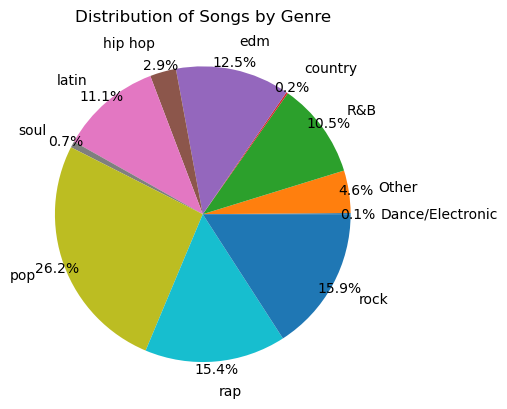

In [413]:
plt.pie(Total_song_genre, labels=Total_song_genre.index, autopct='%1.1f%%', pctdistance=1.05, labeldistance = 1.2)
plt.title('Distribution of Songs by Genre')
plt.show()

In [238]:
#This data is for question 2 (duration)

In [239]:
avg_duration = big_df.groupby('main_genre')['duration_ms'].mean().sort_values(ascending = False)
avg_min = avg_duration / 60000
avg_min

main_genre
Dance/Electronic    4.042049
rock                4.001128
R&B                 3.968907
hip hop             3.885630
edm                 3.848132
pop                 3.685785
latin               3.647511
Other               3.606211
soul                3.575985
rap                 3.520967
country             3.362379
Name: duration_ms, dtype: float64

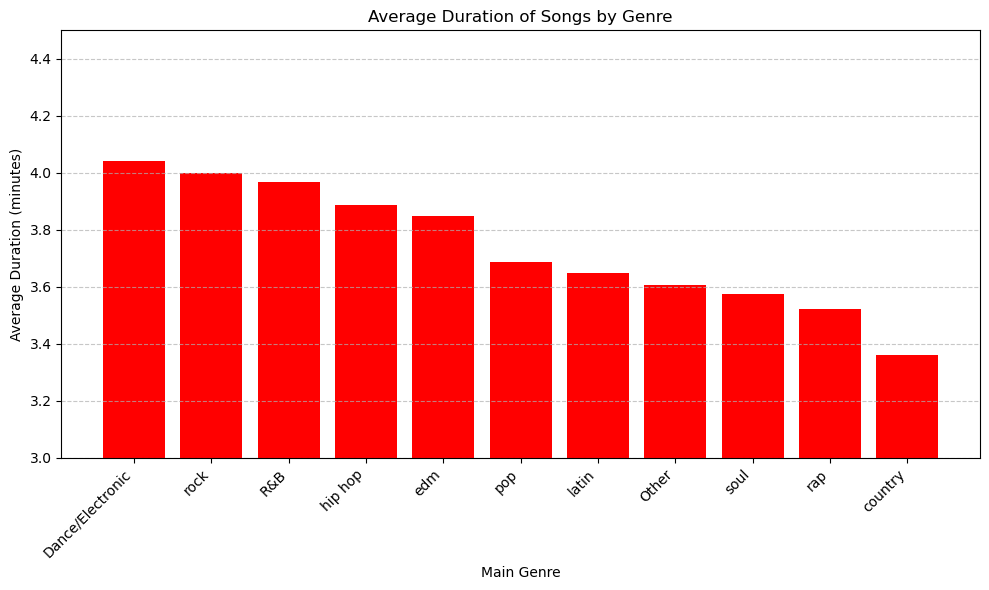

In [240]:
#chart 2 
plt.figure(figsize=(10, 6))
plt.bar(avg_min.index, avg_min.values, color= 'red')
plt.xlabel('Main Genre')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Duration of Songs by Genre')
plt.xticks(rotation=45, ha='right')
plt.ylim(3.0, 4.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the bar graph
plt.tight_layout()
plt.show()

In [241]:
#On avgeage what genre has the fastest tempo 
avg_tempo = big_df.groupby('main_genre')['tempo'].mean().sort_values(ascending = False)
avg_tempo

main_genre
country             129.660377
edm                 126.247145
Dance/Electronic    124.891892
rock                124.438743
Other               121.578216
pop                 121.144841
rap                 120.619446
latin               119.000307
hip hop             117.884798
soul                117.823529
R&B                 113.890473
Name: tempo, dtype: float64

In [242]:
#years with the most songs in the dataset 
Total_song_year = big_df.groupby('year')['song'].count().sort_values(ascending = False)
Total_song_year

year
2019.0    6172
2018.0    2516
2017.0    1913
2016.0    1620
2015.0    1505
          ... 
1961.0       8
1958.0       7
1959.0       3
1957.0       2
1956.0       1
Name: song, Length: 68, dtype: int64

In [243]:
chart3 =  big_df[['main_genre','tempo', 'minutes']]
chart3

,main_genre,tempo,minutes
0,pop,95.0,3.519333
1,rock,149.0,2.784433
2,pop,137.0,4.175767
3,rock,120.0,3.741550
4,pop,173.0,3.342667
...,...,...,...
32827,R&B,106.0,4.855333
32828,R&B,127.0,5.011550
32829,R&B,100.0,2.847333
32830,R&B,76.0,2.703333


In [244]:
#comparison across genre 
genre_compare_df = big_df.groupby('main_genre')[['loudness', 'tempo', 'minutes']].mean()
#genre_compare_df.plot.scatter( 'loudness', 'tempo', s = genre_compare_df['minutes'] * 1000)
genre_compare_df

,loudness,tempo,minutes
main_genre,,,
Dance/Electronic,-5.968946,124.891892,4.042049
Other,-8.297442,121.578216,3.606211
R&B,-8.068679,113.890473,3.968907
country,-8.380755,129.660377,3.362379
edm,-5.553183,126.247145,3.848132
hip hop,-5.778588,117.884798,3.885630
latin,-6.541792,119.000307,3.647511
pop,-6.589017,121.144841,3.685785
rap,-7.170953,120.619446,3.520967


In [245]:
#Data below is for tempo analysis

In [246]:
#what are the top 25 songs with the fastest tempo
top25 = big_df.sort_values('tempo').tail(25)
top25 = top25.sort_values(by='tempo', ascending = False)
top25

,song,artist,year,duration_ms,key,loudness,mode,tempo,main_genre,decade,minutes
19744,Dope's Gotta Hold On Me (feat. Ese Rich Roc),Spanish F.L.Y.,2010.0,113817,7.0,-13.420,1.0,239.0,latin,2010s,1.896950
27859,Long Island,Rob Stepwart,2018.0,115636,2.0,-6.049,1.0,220.0,edm,2010s,1.927267
18129,It's Only Time,Cabela and Schmitt,2017.0,271789,5.0,-8.509,1.0,220.0,latin,2010s,4.529817
1501,Spin the Black Circle - Remastered,Pearl Jam,1994.0,167613,2.0,-4.719,0.0,218.0,rock,1990s,2.793550
1623,Bless My Soul,Powderfinger,2004.0,246320,8.0,-3.811,1.0,216.0,rock,2000s,4.105333
25435,Start Again (feat. Andrea Cormier),Pomo,2014.0,246355,7.0,-6.179,0.0,215.0,R&B,2010s,4.105917
18631,Permitame,Tony Dize,2008.0,185013,8.0,-6.958,1.0,214.0,latin,2000s,3.083550
21078,Permitame (feat. Yandel),Tony Dize,2009.0,184507,8.0,-7.272,1.0,214.0,latin,2000s,3.075117
4989,Warm Water - Snakehips Remix,BANKS,2013.0,253585,4.0,-6.858,0.0,212.0,pop,2010s,4.226417
21033,Machika,J Balvin,2018.0,181733,9.0,-3.362,1.0,212.0,latin,2010s,3.028883


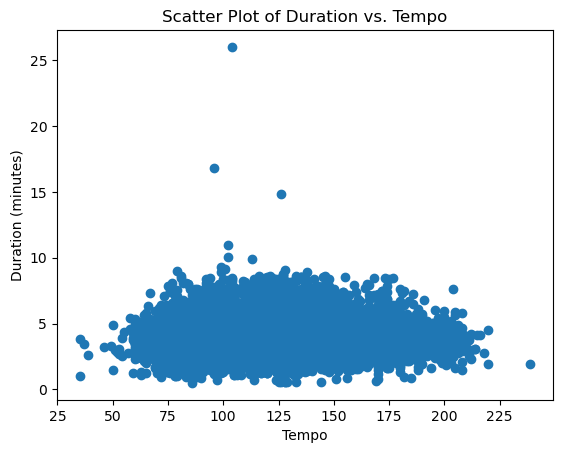

In [247]:
plt.scatter(big_df['tempo'], big_df['minutes'])
plt.xlabel('Tempo')
plt.ylabel('Duration (minutes)')
plt.title('Scatter Plot of Duration vs. Tempo')
plt.show()

In [248]:
#creating a pop df
pop_df = big_df[big_df['main_genre'] == 'pop']

In [249]:
#creating a rock df
rock_df = big_df[big_df['main_genre'] == 'rock']

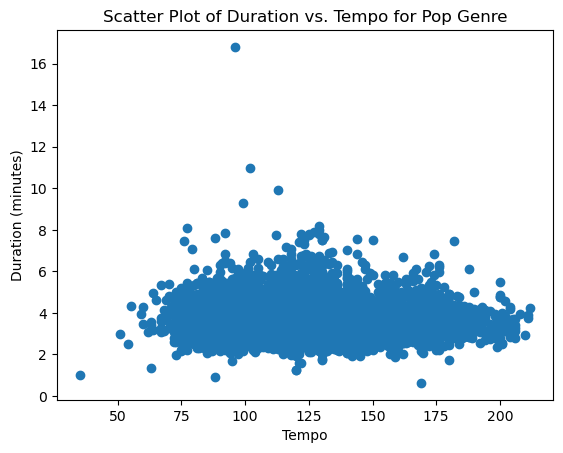

In [250]:
plt.scatter(pop_df['tempo'], pop_df['minutes'])
plt.xlabel('Tempo')
plt.ylabel('Duration (minutes)')
plt.title('Scatter Plot of Duration vs. Tempo for Pop Genre')
plt.show()

In [251]:
tempo_df_all = big_df[['main_genre', 'tempo']].copy()
# bin_edges = np.arange(0, 241, 4)
# tempo_df['tempo_bins'] = (pd.cut(tempo_df['tempo'], bins=bin_edges, labels=bin_edges[1:])).astype(str)
tempo_df = tempo_df_all[~tempo_df_all['main_genre'].isin(['Other', 'set()'])]
tempo_df = tempo_df.sort_values(by='tempo')
tempo_df

,main_genre,tempo
1204,pop,35.0
13556,rock,37.0
5628,rap,39.0
25497,R&B,46.0
22520,R&B,49.0
...,...,...
1623,rock,216.0
1501,rock,218.0
27859,edm,220.0
18129,latin,220.0


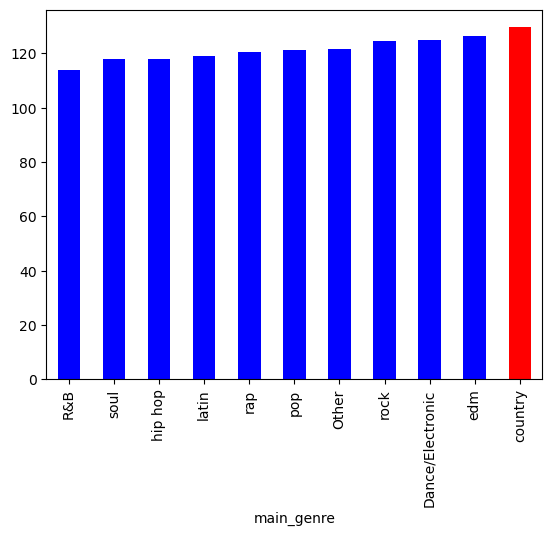

In [252]:
tempo_detail = tempo_detail.sort_values('tempo', ascending=True)
tempo_detail['tempo'].plot(kind='bar', color=['blue'] * (len(tempo_detail) - 1) + ['red'])
plt.show()

In [253]:
#tempo further analysis
tempo_detail = big_df.groupby('main_genre')[['tempo']].mean()
tempo_detail['tempo_stdev'] = big_df.groupby('main_genre')[['tempo']].std()
tempo_detail['min'] = big_df.groupby('main_genre')[['tempo']].min()
tempo_detail['max'] = big_df.groupby('main_genre')[['tempo']].max()
tempo_detail['difference'] = big_df.groupby('main_genre')[['tempo']].max() - big_df.groupby('main_genre')[['tempo']].min()
tempo_detail

,tempo,tempo_stdev,min,max,difference
main_genre,,,,,
Dance/Electronic,124.891892,15.251200,91.0,174.0,83.0
Other,121.578216,25.207807,35.0,203.0,168.0
R&B,113.890473,28.803188,46.0,215.0,169.0
country,129.660377,30.585909,77.0,206.0,129.0
edm,126.247145,14.248621,60.0,220.0,160.0
hip hop,117.884798,28.193358,60.0,208.0,148.0
latin,119.000307,29.172368,60.0,239.0,179.0
pop,121.144841,25.651947,35.0,212.0,177.0
rap,120.619446,31.427930,39.0,212.0,173.0


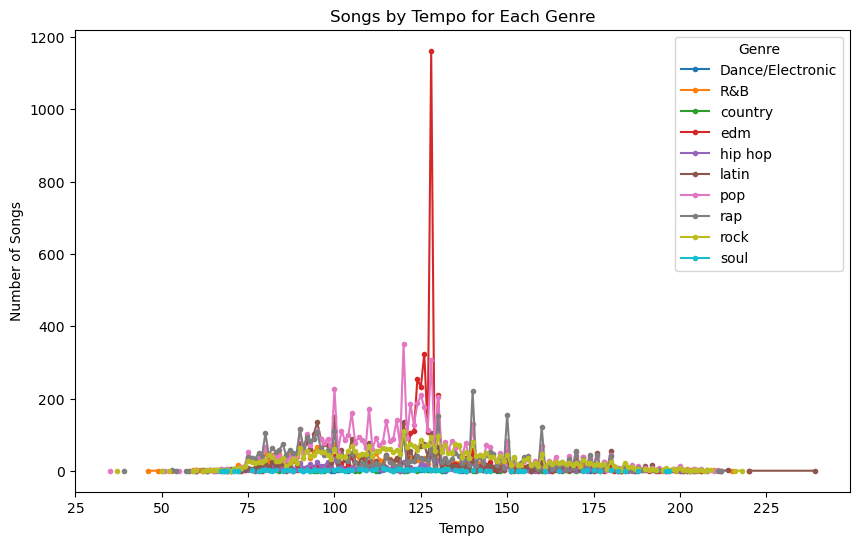

In [254]:
tempo_counts = tempo_df.groupby(['main_genre', 'tempo']).size().reset_index(name='count')

pivot_df = tempo_counts.pivot(index='tempo', columns='main_genre', values='count')

pivot_df.plot(kind='line', marker='.', figsize=(10, 6))
plt.title('Songs by Tempo for Each Genre')
plt.xlabel('Tempo')
plt.ylabel('Number of Songs')
plt.legend(title='Genre')
plt.show()

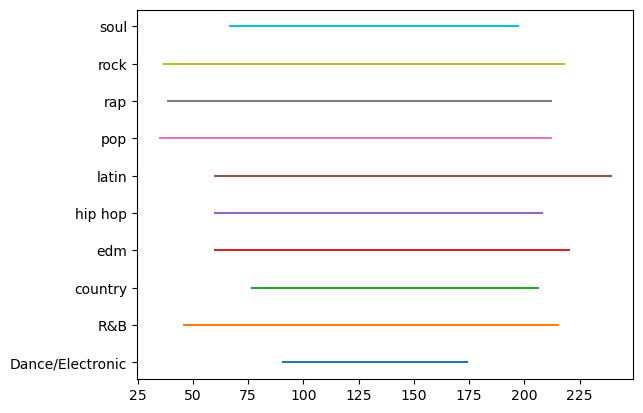

In [255]:
#figure out how to order by size 
import matplotlib.pyplot as plt
for genre, group in tempo_counts.groupby('main_genre'):
    plt.plot(group['tempo'], group['main_genre'], label=genre)

In [428]:
#Next Section is examaining the modality


In [427]:
#mode count by genre (fixed)
mode_counts = big_df.groupby('main_genre')['mode'].value_counts()
mode_counts

main_genre        mode
Dance/Electronic  1.0       21
                  0.0       16
Other             1.0      976
                  0.0      392
R&B               1.0     1606
                  0.0     1480
country           1.0       51
                  0.0        2
edm               1.0     1908
                  0.0     1770
hip hop           1.0      455
                  0.0      387
latin             1.0     1843
                  0.0     1413
pop               1.0     4879
                  0.0     2826
rap               1.0     2380
                  0.0     2166
rock              1.0     3344
                  0.0     1333
soul              1.0      152
                  0.0       52
Name: mode, dtype: int64

In [258]:
mode_perc = big_df.groupby('main_genre')['mode'].value_counts(normalize=True).rename('percentage').reset_index()

mode_perc['percentage'] = (mode_perc['percentage'] * 100).round(2)
#function to detect the type of key it is in 
mode_perc['type'] = mode_perc['mode'].apply(lambda x: 'Major' if x == 1 else 'Minor')
# rearranging the order of the columns
mode_perc = mode_perc.iloc[:,[0,1,3,2]] #reordering the columns 
mode_perc

,main_genre,mode,type,percentage
0,Dance/Electronic,1.0,Major,56.76
1,Dance/Electronic,0.0,Minor,43.24
2,Other,1.0,Major,71.35
3,Other,0.0,Minor,28.65
4,R&B,1.0,Major,52.04
5,R&B,0.0,Minor,47.96
6,country,1.0,Major,96.23
7,country,0.0,Minor,3.77
8,edm,1.0,Major,51.88
9,edm,0.0,Minor,48.12


Enter a music genre:  country


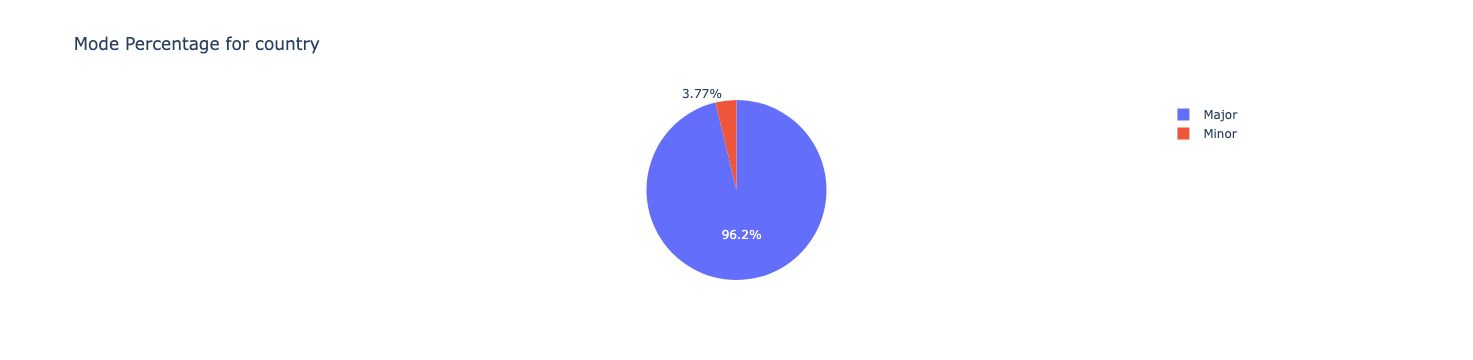

In [434]:
#cleaner code than below (let John and Bella decide which ones stay in)
genre = input("Enter a music genre: ")
selected_data = mode_perc[mode_perc['main_genre'] == genre.lower()]

if not selected_data.empty:
    fig = go.Figure(data=[go.Pie(labels=selected_data['type'], values=selected_data['percentage'])])
    fig.update_layout(title=f'Mode Percentage for {genre}')
    fig.show()
else:
    print("Genre not found in the dataset")

In [435]:
pop_data = mode_perc[mode_perc['main_genre'] == 'pop']
edm_data = mode_perc[mode_perc['main_genre'] == 'edm']
rock_data = mode_perc[mode_perc['main_genre'] == 'rock']
rnb_data = mode_perc[mode_perc['main_genre'] == 'R&B']
hiphop_data =  mode_perc[mode_perc['main_genre'] == 'hip hop']
latin_data = mode_perc[mode_perc['main_genre'] == 'latin']
other_data = mode_perc[mode_perc['main_genre'] == 'Other']
soul_data = mode_perc[mode_perc['main_genre'] == 'soul']
rap_data = mode_perc[mode_perc['main_genre'] == 'rap']
electronic_data = mode_perc[mode_perc['main_genre'] == 'Dance/Electronic']
country_data = mode_perc[mode_perc['main_genre'] == 'country']


Enter a music genre:  country


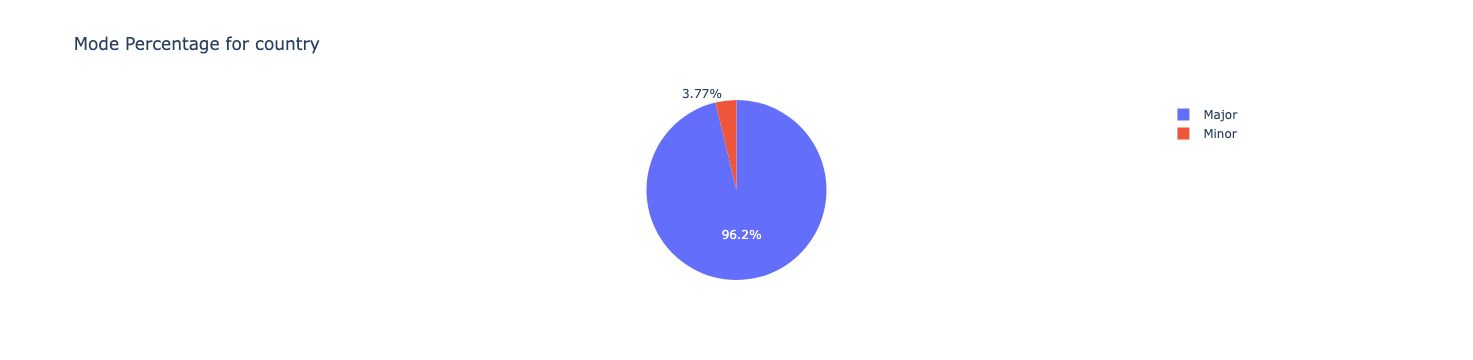

In [68]:
import plotly.graph_objects as go

#dictionary mapping to select what dataset you want to use 
music_genres = {
    "Dance/Electronic": electronic_data,
    "rock": rock_data,
    "r&b": rnb_data,
    "hip hop": hiphop_data,
    "edm": edm_data,
    "pop": pop_data,
    "latin": latin_data,
    "other": other_data,
    "soul": soul_data,
    "rap": rap_data,
    "country": country_data
}

genre = input("Enter a music genre: ")
selected_data = music_genres.get(genre, None)

if selected_data is not None:
    fig = go.Figure(data=[go.Pie(labels=selected_data['type'], values=selected_data['percentage'])])
    fig.update_layout(title=f'Mode Percentage for {genre}')
    fig.show()
else:
    print("Genre not found in the dictionary")

In [144]:
#This section will be exmaining duration of songs by genre 

In [145]:
#This section will be examaining are songs getting longer throughout the decades

In [262]:
#Total Song count by decade 
songs_count_by_decade = big_df.groupby('decade').size().reset_index(name='count')
songs_count_by_decade


,decade,count
0,1950s,13
1,1960s,429
2,1970s,1034
3,1980s,1368
4,1990s,2419
5,2000s,4960
6,2010s,18241
7,2020s,988


Text(0, 0.5, 'Song Count')

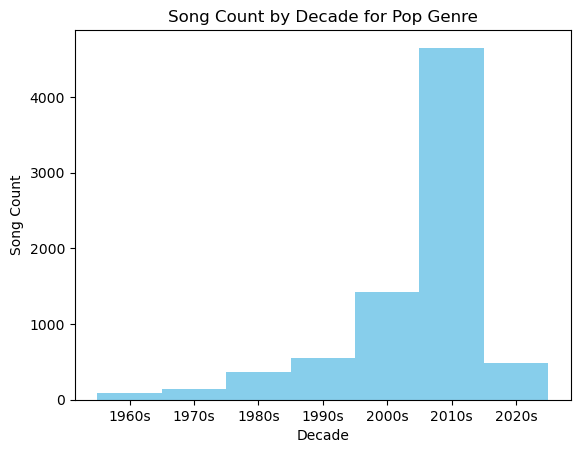

In [332]:
#static pop example
pop_data = big_df[big_df['main_genre'] == 'pop']
song_count_by_decade = pop_data.groupby('decade')['song'].count()
plt.bar(song_count_by_decade.index, song_count_by_decade.values,width=1, color='skyblue')
plt.title('Song Count by Decade for Pop Genre')
plt.xlabel('Decade')
plt.ylabel('Song Count')

Enter a music genre:  pop


Text(0, 0.5, 'Song Count')

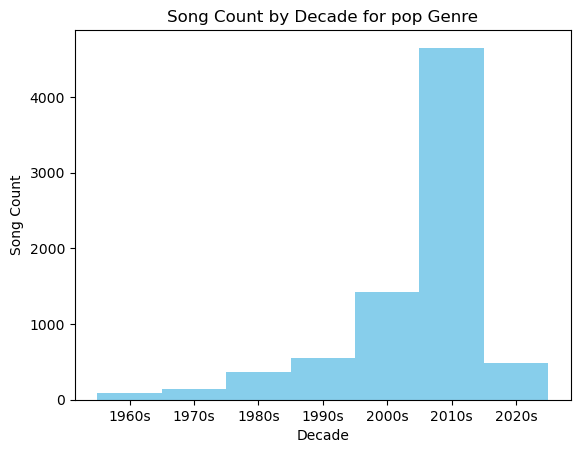

In [336]:
genre = input("Enter a music genre: ")
selected_data = big_df[big_df['main_genre'] == genre.lower()]
selected_data = selected_data.groupby('decade')['song'].count()
plt.bar(selected_data.index, selected_data.values,width=1, color='skyblue')
plt.title('Song Count by Decade for ' + genre + ' Genre')
plt.xlabel('Decade')
plt.ylabel('Song Count')

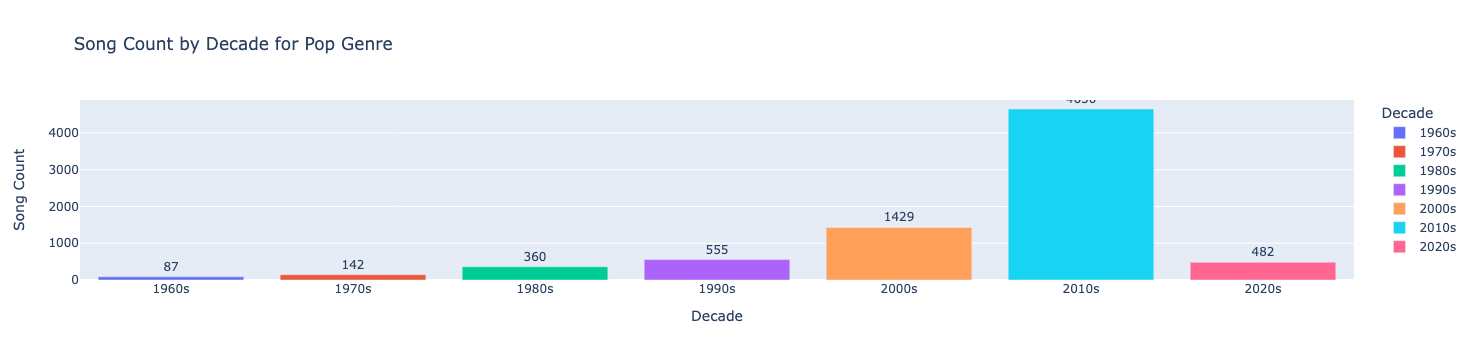

In [338]:
import plotly.express as px #im unsure if the group will understand the code 
pop_data = big_df[big_df['main_genre'] == 'pop']

# Group by decade and count the songs
song_count_by_decade = pop_data.groupby('decade')['song'].count().reset_index(name='count')

# Create the bar chart
fig = px.bar(song_count_by_decade, x='decade', y='count', text='count', color='decade', 
             title='Song Count by Decade for Pop Genre', labels={'decade': 'Decade', 'count': 'Song Count'})
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.show()

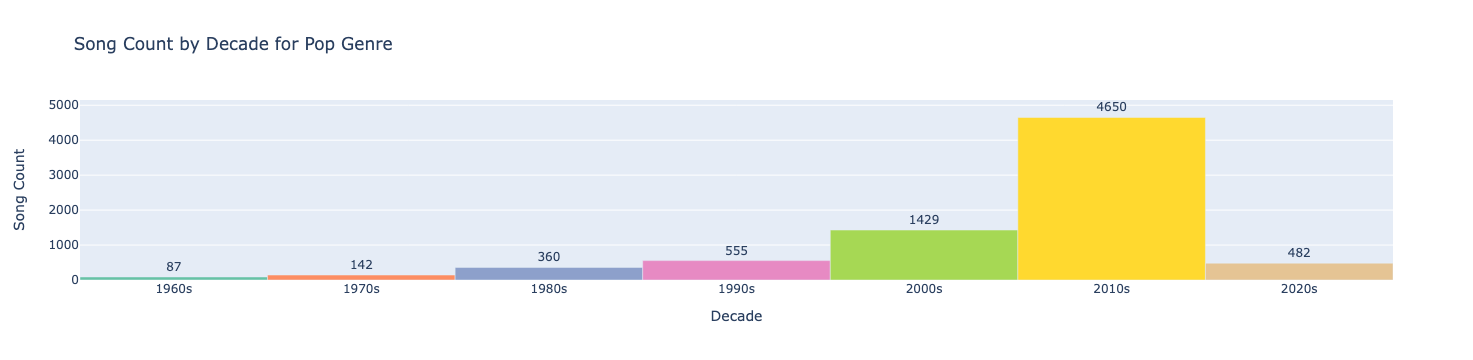

In [436]:
import plotly.graph_objects as go

# Create the bar chart
fig = go.Figure(data=go.Bar(x=song_count_by_decade['decade'], y=song_count_by_decade['count'], 
                             marker_color= px.colors.qualitative.Set2, text=song_count_by_decade['count']))
fig.update_layout(title='Song Count by Decade for Pop Genre', xaxis_title='Decade', yaxis_title='Song Count')
fig.update_traces(textposition='outside')
fig.update_layout(bargap = 0)
max_count = song_count_by_decade['count'].max() + 500 #make sure to see all labels
fig.update_yaxes(range=[0, max_count])  
# Show the bar chart
fig.show()

Enter a music genre:  rock


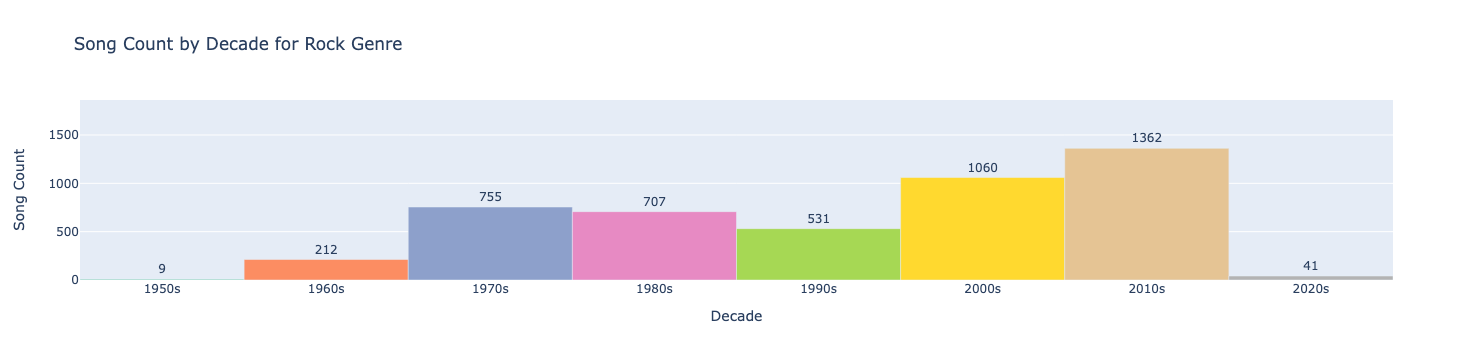

In [440]:
genre = input("Enter a music genre: ")
selected_data = big_df[big_df['main_genre'] == genre.lower()]
selected_data = selected_data.groupby('decade')['song'].count().reset_index()
fig = go.Figure(data=go.Bar(x=selected_data['decade'], y=selected_data['song'], 
                             marker_color=px.colors.qualitative.Set2, text=selected_data['song']))
fig.update_layout(title='Song Count by Decade for ' + genre.capitalize() + ' Genre', xaxis_title='Decade', yaxis_title='Song Count')
fig.update_traces(textposition='outside')
fig.update_layout(bargap=0)
max_count = selected_data['song'].max() + 500  # make sure to see all labels
fig.update_yaxes(range=[0, max_count])  
# Show the bar chart
fig.show()

In [284]:
dec = big_df
dec = dec.groupby('decade').mean(numeric_only=True)
dec
#ord_dec2(pop_dec).dropna()

,year,duration_ms,key,loudness,mode,tempo,minutes
decade,,,,,,,
1950s,1957.923077,158131.076923,3.923077,-8.118615,0.769231,137.846154,2.635518
1960s,1965.759907,183820.391608,5.000000,-9.827005,0.813520,120.855478,3.063673
1970s,1974.742747,244470.624758,5.106383,-9.920285,0.777563,121.201161,4.074510
1980s,1985.022661,258541.584064,5.247076,-9.585219,0.722222,122.492690,4.309026
1990s,1995.003721,256656.458867,5.427863,-8.587738,0.635800,117.200496,4.277608
2000s,2005.169153,238344.592944,5.370161,-6.593592,0.621169,120.395766,3.972410
2010s,2016.404583,216863.874842,5.346363,-6.447299,0.563949,121.772929,3.614398
2020s,2020.355263,195625.689271,5.341093,-6.489652,0.564777,121.123482,3.260428


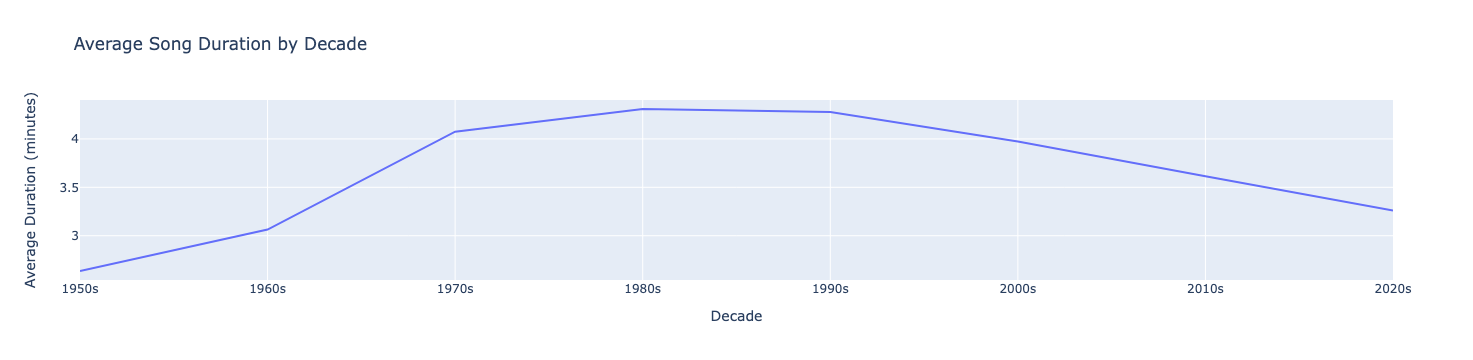

In [285]:
fig = go.Figure(data=go.Scatter(x=dec.index, y = dec['minutes'], mode='lines'))

fig.update_layout(title='Average Song Duration by Decade', xaxis_title='Decade', yaxis_title='Average Duration (minutes)')



In [ ]:
#dynamic and interactive chart based off of the static one above

Enter a music genre:  rock


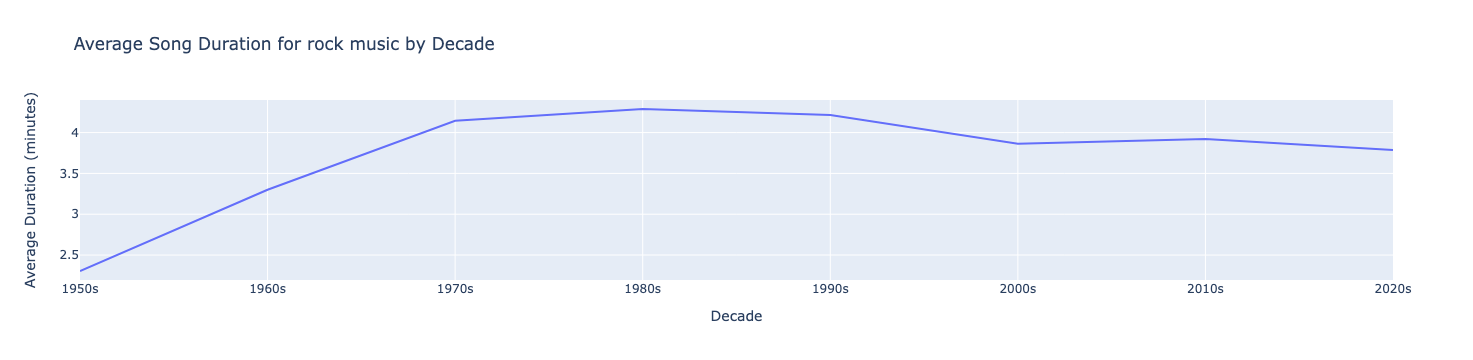

In [441]:
genre = input("Enter a music genre: ")
selected_data = big_df[big_df['main_genre'] == genre.lower()]
selected_data = selected_data.groupby('decade').mean(numeric_only=True)
fig = go.Figure(data=go.Scatter(x=selected_data.index, y = selected_data['minutes'], mode='lines'))
fig.update_layout(title='Average Song Duration for ' + genre +' music by Decade', xaxis_title='Decade', yaxis_title='Average Duration (minutes)')


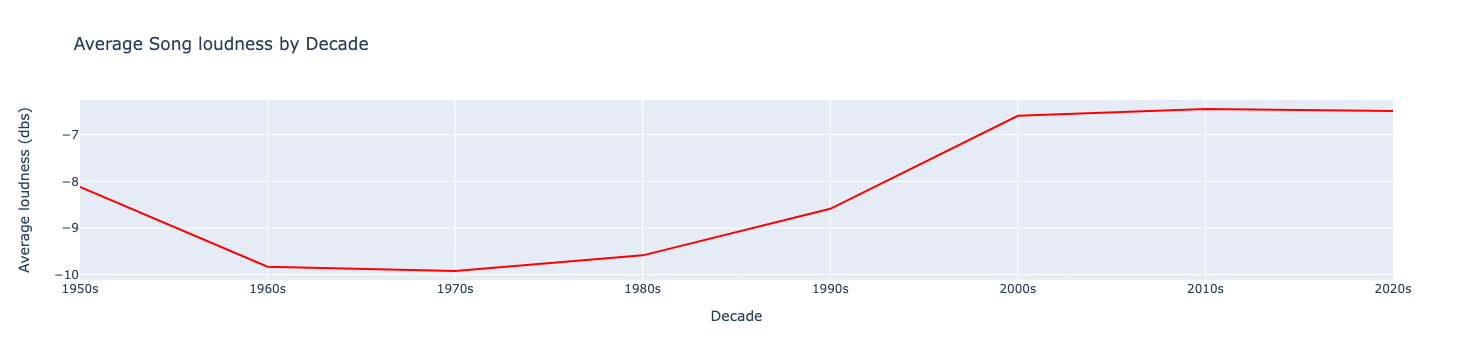

In [295]:
#Are songs getting Louder? 
# -7 is louder than -10, meaning songs are at an all time high in loudness 
fig = go.Figure(data=go.Scatter(x=dec.index, y = dec['loudness'], mode='lines'))
fig.update_traces(line_color='red')
fig.update_layout(title='Average Song loudness by Decade', xaxis_title='Decade', yaxis_title='Average loudness (dbs)')

Enter a music genre:  PoP


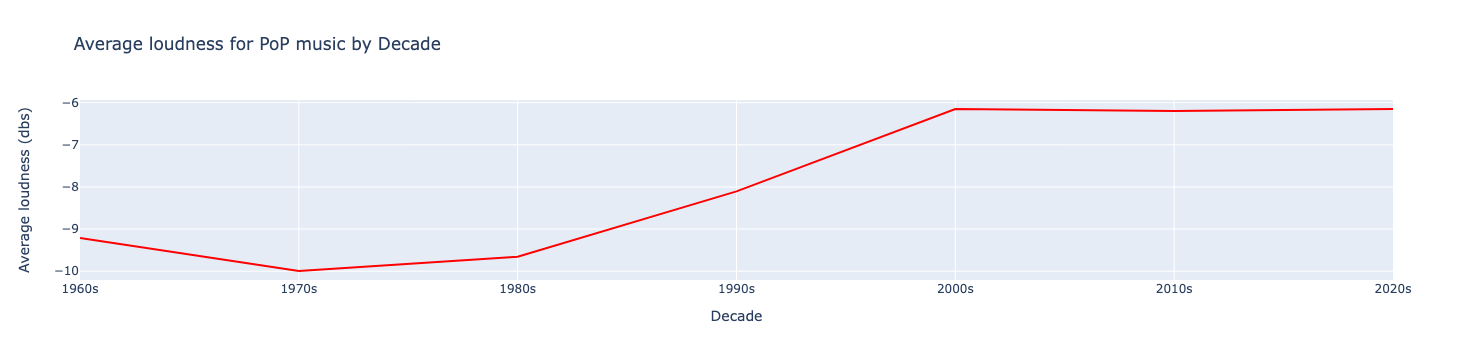

In [443]:
#dynamic and more in-depth
genre = input("Enter a music genre: ")
selected_data = big_df[big_df['main_genre'] == genre.lower()]
selected_data = selected_data.groupby('decade').mean(numeric_only=True)
fig = go.Figure(data=go.Scatter(x=selected_data.index, y = selected_data['loudness'], mode='lines'))
fig.update_traces(line_color='red')
fig.update_layout(title='Average loudness for ' + genre +' music by Decade', xaxis_title='Decade', yaxis_title='Average loudness (dbs)')


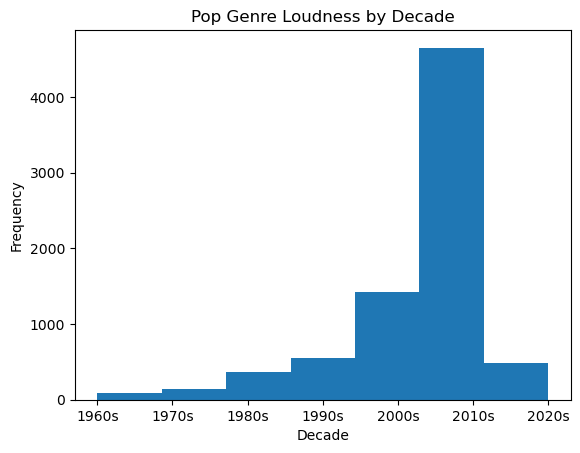

In [445]:
#distributions song count by decade 
pop_data = big_df[big_df['main_genre'] == 'pop']
pop_data = pop_data.sort_values(by='decade', ascending=True)
plt.hist(pop_data['decade'], bins = 7) # Adjust the number of bins as needed
plt.title('Pop Genre Loudness by Decade')
plt.xlabel('Decade')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

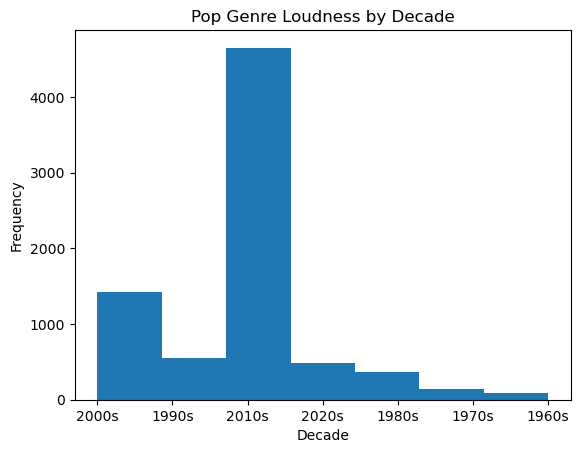

In [444]:
pop_data = big_df[big_df['main_genre'] == 'pop']
x_data = pop_data.groupby('decade').size().reset_index(name='count')
x = x_data.shape[0]
plt.hist(pop_data['decade'], bins = x ) # Adjust the number of bins as needed
plt.title('Pop Genre Loudness by Decade')
plt.xlabel('Decade')
plt.ylabel('Frequency')

# Show the histogram
plt.show()